# Environment setup

In [111]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Library preparation

In [112]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
import time, os, io, clipboard
from PIL import ImageGrab
from IPython.display import Image, display
from scipy import stats
from si_prefix import si_format
from math import *
from tqdm import tqdm, tqdm_notebook

from io import StringIO 
import pandas as pd
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

from JJ_data_processing import *
from JJformulas import *

import sys 
sys.path.append('..')
from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment, experiments)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

### Database ini

In [114]:
SAMPLE = '79N6'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

## Scripts

### Data proc

In [115]:
def extract_Isw_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']

        
    return extract_Isw (Is,Vs)

def extract_Isw (Is,Vs):
    
        if len( Is )== 0 or len( Vs )== 0 :
            Isw, R0 = np.nan, np.nan
            return Isw, R0
        
        Isw = abs(np.max(Is)) 
        

        
        return Isw

In [116]:
def extract_Isw_R0 (Is,Vs):

    Isw = (np.max(Is) - np.min(Is) ) /2

    order = Is.argsort()        
    Is, Vs = Is[order], Vs[order]
    n = len(Is)
    n_min, n_max = np.int(n/3), np.int(2*n/3)        
    n_sl = slice(n_min, n_max)

    R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))        
    return Isw, R0

def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
        
    return extract_Isw_R0 (Is,Vs)

In [117]:
def xy_by_id(idx):
    alldata = get_data_by_id(idx)
    
    x = alldata[0][0]['data']
    y = alldata[0][1]['data']
    
    return x,y

In [118]:
def batch_plot_by_id(ids, ax = None, labels = None, **kw):
    if ax is None:
        fig, ax = plt.subplots()
        
    for i, idx in enumerate(ids):
        if labels is not None:
            label = labels[i]
        else:
            label = ''
            
        plot_by_id(idx, axes = ax, label = label, **kw)
        
    ax.legend()
    

In [119]:
def JJpar(RN, JJwidthUM=0.2, metalTHK=250E-10, Tc=1.34):
   
    Rs_JJ = RN * ( (JJwidthUM*1E-6 + 2*metalTHK) *JJwidthUM*1E-6 )
    IAB = const.pi *1.764 *const.k *Tc /2 /const.e /RN
    EJ_JJ = const.h /2 /const.e /2 /const.pi *IAB
    C_JJ = 50E-15 *JJwidthUM *JJwidthUM
    EC_JJ = const.e *const.e /2 /C_JJ
    C0 = ParplateCap(area= 56*1E-12 , dielecTHK=10E-9, epsilon = 9.34*const.epsilon_0)
    EC0 = const.e *const.e /2 /C0
   
    freqPlasma = sqrt(2 *const.e *IAB *2*const.pi /const.h /max(C0,C_JJ)) /2/const.pi
    Q = freqPlasma*2*pi *RN *max(C0,C_JJ)
    EJoEc = EJ_JJ/min(EC0,EC_JJ)

#     key =  [ 'RN_JJ',   'Rs_JJ', 'I_AB',   'EJ', 'C_JJQP',   'EC', 'C0', 'EC0', 'Freq_plasma', 'Q', 'Beta', 'EJ/EC']
#     unit=  [   'ohm', 'ohm-m^2',    'A',    'J',      'F',    'J',  'F',   'J',          'Hz',  '',     '',      '']
#     lst = [[     RN ,    Rs_JJ ,   IAB , EJ_JJ ,    C_JJ , EC_JJ ,  C0 ,  EC0 ,    freqPlasma,  Q ,   Q*Q ,  EJoEc ]]
    key =  [ 'RN_JJ',    'Rs_JJ', 'I_AB',           'EJ',  'C_JJQP',          'EC',    'C0',       'EC0',  'Freq_plasma', 'Q', 'Beta', 'EJ/EC']
    unit=  [  'kohm','kohm*um^2',   'nA',            'K',      'fF',           'K',    'fF',         'K',          'GHz',  '',     '',      '']
    lst = [[ RN/1e3 , Rs_JJ*1e9 ,IAB*1e9, EJ_JJ/const.k , C_JJ*1e15, EC_JJ/const.k, C0*1e15, EC0/const.k, freqPlasma/1e9,  Q ,   Q*Q ,  EJoEc ]]
    JJparDFM =   pd.DataFrame(  data  = list(zip(*lst)),
                                index = key ).transpose()
    JJparUNI =   dict(zip(key, unit))

    return JJparDFM,JJparUNI

def ParplateCap(area, dielecTHK, epsilon = 9.34*const.epsilon_0):
    C = epsilon *area /dielecTHK
    return C

In [120]:
devlst = {'D079N1': JJpar(RN=  290e3/.5, JJwidthUM=np.sqrt( .177 *  .177)),
          'D079N3': JJpar(RN=  520e3/ 8, JJwidthUM=np.sqrt( .784 *  .263)),
          'D079N5': JJpar(RN=   27e3/ 8, JJwidthUM=np.sqrt( 2.25 *  1.74)),
          'D079N6': JJpar(RN= 2.15e3/.5, JJwidthUM=np.sqrt( 2.21 *  1.72)),
          'D079N0': JJpar(RN= 24.3e3/ 8, JJwidthUM=np.sqrt( 2.21 *  1.67))}

a     = devlst['D079N1'][0]
unit  = devlst['D079N1'][1]
idlst = []
for dev in devlst:
    a = a.merge(devlst[dev][0], 'outer')
    idlst.append(dev)
   
a.insert(loc = 0, column = 'dev id', value = idlst)
a

,dev id,RN_JJ,Rs_JJ,I_AB,EJ,C_JJQP,EC,C0,EC0,Freq_plasma,Q,Beta,EJ/EC
0,D079N1,580.0000,23.303820,0.551656,0.013150,1.56645,0.593460,463.10944,0.002007,0.302792,511.017683,261139.072095,6.550834
1,D079N3,65.0000,14.878252,4.922465,0.117337,10.30960,0.090171,463.10944,0.002007,0.904486,171.071873,29265.585666,58.453599
2,D079N5,3.3750,13.547020,94.803031,2.259825,195.75000,0.004749,463.10944,0.002007,3.969370,38.981525,1519.559256,1125.773023
3,D079N6,4.3000,16.764338,74.409355,1.773700,190.06000,0.004891,463.10944,0.002007,3.516610,44.000353,1936.031052,883.600919
4,D079N0,3.0375,11.502271,105.336701,2.510917,184.53500,0.005038,463.10944,0.002007,4.184083,36.981121,1367.603330,1250.858914


#### Exps

In [121]:
FF_ = .230e-3
ZF_ = -.00e-3

def populate_exps (exps,ZF_ = .004e-3, FF_ = .232e-3, VERBOSE = False):

    texps = tqdm_notebook(exps)
    for exp in texps:

        Isws = []
        R0s = []

        if VERBOSE:
            fig, ax = plt.subplots()

        Is = []
        Vs = []

        Irs = []
        Vrs = []

        Ils = []
        Vls = []

        for i in exp['ids']:

            I, V = xy_by_id(i)

            Tb = exp['T']

            ind_Vmax = np.argmax(I)
            ind_Vmin = np.argmin(I)

            ind_I0 = np.argmin(abs(I - 0e-12))
            ind_near0 = np.where(abs(I) > 0e-9)

            V_off = np.mean(V[ind_near0])
            V -= V_off

            I, V = cut_dxdy(I, V, dx = 250e-9 ,dy = 10e-6)

            V_off = np.mean(V)
            V -= V_off

    
            g0 = np.where(I>0)
            l0 = np.where(I<0)

            Ir, Vr = I[g0], V[g0]
            Il, Vl = I[l0], V[l0]


            if VERBOSE:
                ax.plot(I,V, 'o')

            Isw, R0 = extract_Isw_R0 (I,V)
            Isws.append(Isw)
            R0s.append(R0)


            Is.append(I)
            Vs.append(V)

            Irs.append(Ir)
            Vrs.append(Vr)

            Ils.append(Il)
            Vls.append(Vl)



        exp ['Is' ] =  Is
        exp ['Vs' ] =  Vs

        exp ['Irs' ] =  Irs
        exp ['Vrs' ] =  Vrs

        exp ['Ils' ] =  Ils
        exp ['Vls' ] =  Vls



        exp ['Isws'] =  np.array(Isws)
        exp ['R0s' ] =  np.array(R0s )
        exp ['cos' ] =  np.array( abs(np.cos(np.pi*(exp['B'] - ZF_ )/(2* (FF_ - ZF_)  )) ) )


#### Hist

In [122]:
def load_hist_by_id(idx):
    _, Isws = xy_by_id(idx)
    return Isws

In [123]:
def plot_hist_by_id(idx, ax = None, cumulative = False ):
    _, Isws = xy_by_id(idx)
    if ax is None:

        fig, ax = plt.subplots()

    ax.hist(Isws, bins = 201, cumulative = cumulative )
    return Isws

In [124]:
def save_hist(Isws, label = ''):     
    N_try = qc.Parameter('try')    

    meas = set_meas( Isrc.I, N_try, setup = setup, cleanup = cleanup)
    name = '{:} @T ={:2.1f}mK'.format(label, T8.get()/1e-3)
    name_exp(sample = SAMPLE, exp_type = name )  
    with meas.run() as datasaver: 
        for j, I in enumerate(Isws):
            res = [ ( N_try, j  ) ,( Isrc.I, I ),]

            datasaver.add_result(*res)
            
    print('Run # {:1.0f}, {:} saved'.format(datasaver.run_id, name))

In [125]:
def fit_hist_by_id(idx, EJ = 4, Ec = 0.05, dIdt = 30e-9, bins = 21):

    def wpK(EjK, EcK):
        return np.sqrt(8*EjK*EcK)
    
    eps = .001
    
    Isw = abs(load_hist_by_id(idx ))

    counts, Ibins = np.histogram(Isw, bins = bins)
    dI = np.mean( np.diff(Ibins) )

    SP = np.cumsum(counts)/len(Isw)
    Gamma = np.array([ np.log( (1 - SP[i])/(1 - SP[i+1]) ) for i in range(len(SP)-1)  ])*dIdt/dI


    Ic = 2*pi*EJ/Φ0*kB
    Ic0 = 1.5 * np.max(Isw)
    Ib = Ibins[:-2]
    
    while abs((Ic - Ic0)/Ic) > eps:
        Ic = Ic0
        wa = wpK(EJ, Ec)*kB/hbar/2/pi * (1 - (Ib/Ic)**2)**0.25

        coeff =  (-np.log(2*pi*Gamma/wa))**(2/3)
        i = np.isfinite(coeff) 
        
        a, b = np.polyfit( Ib[i], coeff[i],1)
        Ic0 = -b/a
        Teff = -1/kB*Φ0/2/pi*4*np.sqrt(2)/3 /np.sqrt(b)/a
    

    return Ic0, Teff

In [126]:
# def fit_plot_hist_by_id(idx, ax = None, EJ = 4, 
#                         Ec = 0.05,dIdt = 30e-9, bins = 21):

#     eps = .001
    
#     Isw = abs(load_hist_by_id( idx ))

#     counts, Ibins = np.histogram(Isw, bins = bins)
    
#     Ib = Ibins[:-2]
    
#     Ic0, Teff, coeff = fit_hist_by_id(idx, EJ = EJ, Ec = Ec,
#                                dIdt = dIdt, bins = bins)
#     print( Ic0, Teff )  

#     if ax is None:
#         fig, ax = plt.subplots()
#         add_legend = True
#     else:
#         add_legend = False
#     l = ax.plot(Ib, coeff, 'x')
#     c = l[0].get_color()
    
#     Iplot = np.linspace(np.min(Ib), Ic0, 101)
#     ax.plot(Ib, a*Ib + b, c = c, ls = '--', 
#             label = 'Tesc = {:1.0f} mK, Ico = {:1.0f} nA'. format(Teff/1e-3, Ic0*1e9))
#     if add_legend:
#         ax.legend()

#     return ax
    

## Measurement plan

- check TA-UPD transition
- compare AWG and Keith for the same scanning time 

#### Constants

In [37]:
ZF =  0.004e-3
FF =  0.224e-3
dF = 0.250e-3
midF = 0.154e-3

from scipy.constants import e, hbar,h, k, pi

Φ0 = h/2/e 
kB = k
Δ = 2.1*kB

## KK 12/17

Plan:

- meas full IVC & TA transition 
- extract Q(0) and Q(wp)
- compare AWG and Keith with the same delay

###  Full IVC

    Meas IVC to extract Ir0, RN to find Q(0) and wp?

<IPython.core.display.Javascript object>


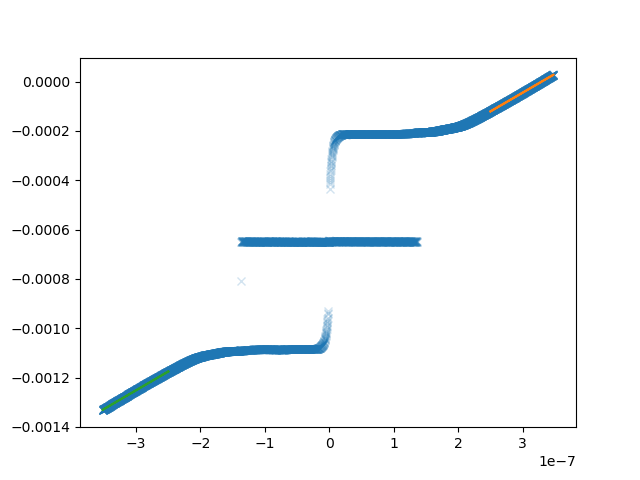

R_pos = 1.5 kohm/JJ, V_off = -361.1 µV/JJ
R_neg = 1.5 kohm/JJ, V_off = 339.8 µV/JJ
C/JJ from 1e/V_off : 210.7 yF


In [131]:
plt.close('all')
f,ax = plt.subplots()

I,V = xy_by_id(1468)

ax.plot(I,V, marker = 'x', ls = 'None', alpha = 0.2)

datSel = np.where(I > 250e-9, True, False)
a_p, b_p = np.polyfit(I[datSel], V[datSel], 1)
ax.plot(I[datSel], I[datSel]*a_p + b_p)

datSel = np.where(I < -250e-9, True, False)
a_n, b_n = np.polyfit(I[datSel], V[datSel], 1)
ax.plot(I[datSel], I[datSel]*a_n + b_n)

print('R_pos = {}ohm/JJ, V_off = {}V/JJ'.format(si_format(a_p), si_format(b_p-497e-6+637e-6)))
print('R_neg = {}ohm/JJ, V_off = {}V/JJ'.format(si_format(a_n), si_format(b_n+497e-6+637e-6)))
print('C/JJ from 1e/V_off : {}F'.format(si_format(1*const.e/((a_p+b_p)/2-497e-6))))

plt.show()

<IPython.core.display.Javascript object>


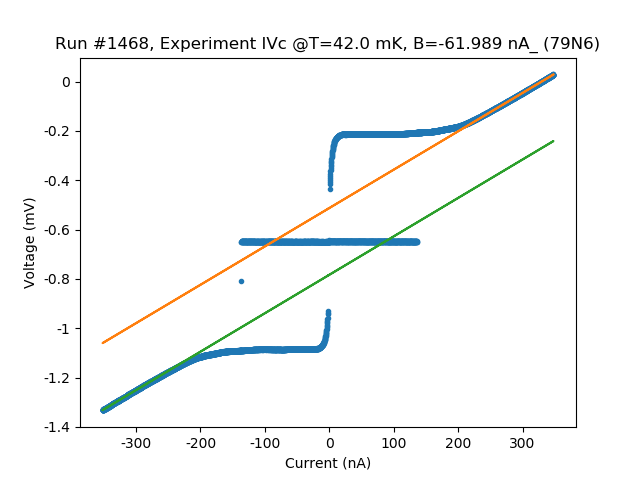

1556.2266489001531 -0.0005125877870277452
1558.7091069849719 -0.0007833524696328562


In [129]:
fig, ax = plt.subplots()

plot_by_id(1468, axes = ax, marker = '.', ls = '')

I, V = xy_by_id(1468)

for cond in [ I > 300e-9 , I < -300e-9]:
    idx = np.where(cond)

    a,b = np.polyfit(I[idx], V[idx], 1)

    print(a,b)

    ax.plot(I, I*a + b)

In [39]:
2*1.6e-19/135e-6

2.37037037037037e-15

In [40]:
RN = 1.56e3
C = 2.37e-15
Ic0 = 200e-9
wp = (2*e*Ic0/hbar/C)**.5
wp/1e9/2/pi

80.59221135206005

In [41]:
200/wp/C

166651.3011625993

RN = 1.56 kOhm

Intercept = 135 uV = 2e/C
C = 2.37 fF


Ic = 200 nA (from hyst + Rn meas)

Q(0) = 4/$\pi$ Ic0/Ir0 = 4/3.14*200/1.2 > 200

wp = 80 GHz ??

Q = wpRC, R(0) = Q/wp/C = 160 kOhm


### TA -UPD transition
    Meas IVC and hist for cos in [.3 - .1] to see narrowing of the distribution/emerging of R0

#### AWG

<IPython.core.display.Javascript object>


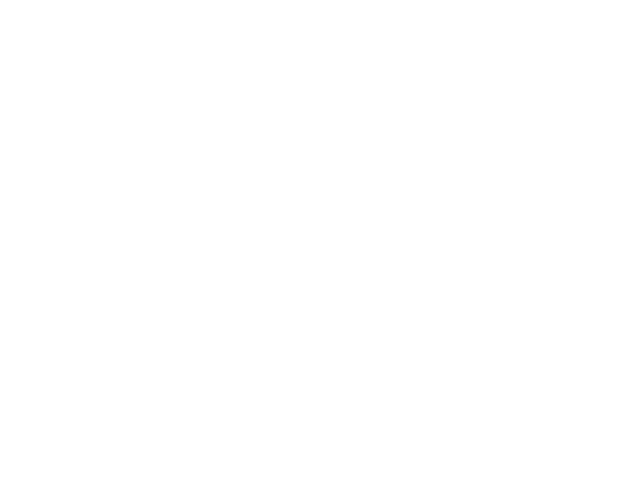

No handles with labels found to put in legend.


In [42]:
# IVC for cos = [.25, .2, .15]
batch_plot_by_id([1435, 1436,1437], marker = '.', ls = '')

<IPython.core.display.Javascript object>


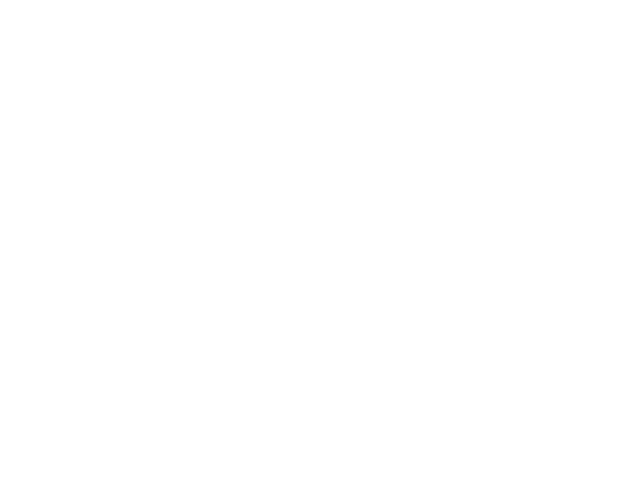

In [43]:
# IVC for cos = np.linspace(.15, 0, 7)
labels = [ 'cos = {:1.2f}'.format(cos) for cos in np.linspace(.15,0,7)]
batch_plot_by_id(range(1472,1478+1),
                 labels = labels,marker = '.', ls = '')

Presumably cos = .15 corresponds to PD. 
Isw = 4/pi*Ic0*cos/Q(wp) = 1 nA
Q(wp) = 40
R(wp) = 33e3

But wp(cos)~ cos**.5, so

R(wp*) = 86e3

#### Mess with Keithley

<IPython.core.display.Javascript object>


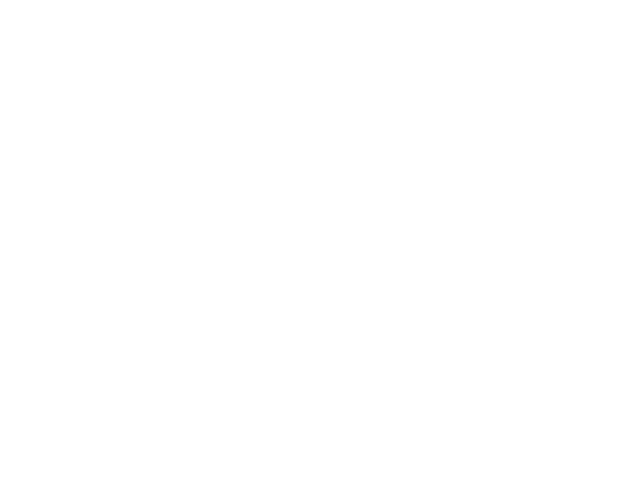

No handles with labels found to put in legend.


In [44]:
batch_plot_by_id(range(1488,1494+1), marker = '.', ls = '')

wth, there are two copies of IV?? although it looks better than awg. 
Measure .1 and .05 for timedelay = .5

<IPython.core.display.Javascript object>


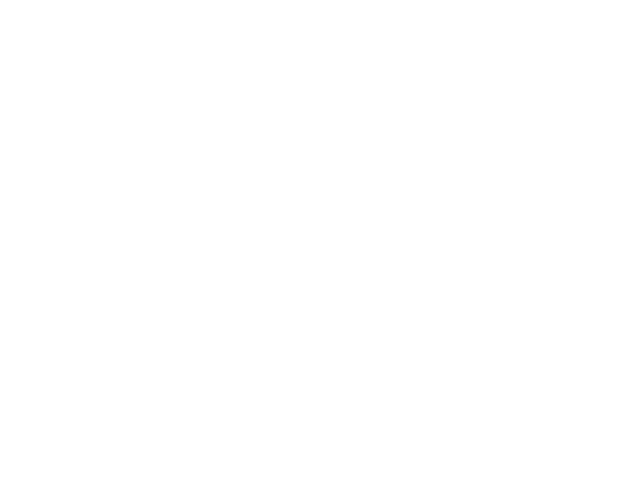

No handles with labels found to put in legend.


In [45]:
batch_plot_by_id(range(1495,1496+1), marker = '.', ls = '')

Ok, it helps. Probably this is due 100 MOhm I have to use in this region. Also should switch to range('fast 6')

tfsstb = 0.1, but fast 6

<IPython.core.display.Javascript object>


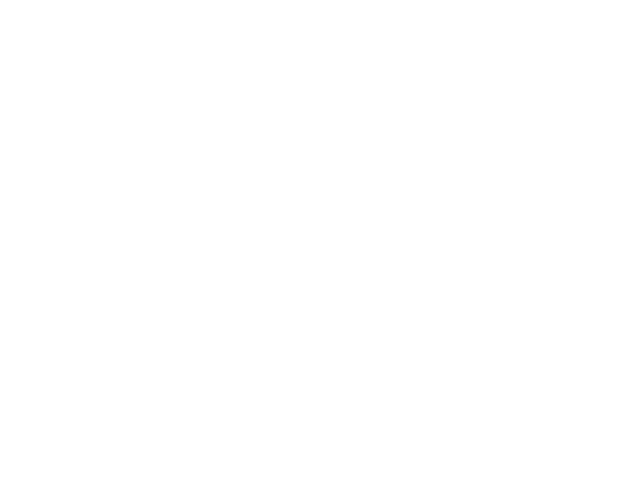

No handles with labels found to put in legend.


In [46]:
batch_plot_by_id(range(1499,1499+1), marker = '.', ls = '')

tfsstb = 0.25

No difference(

<IPython.core.display.Javascript object>


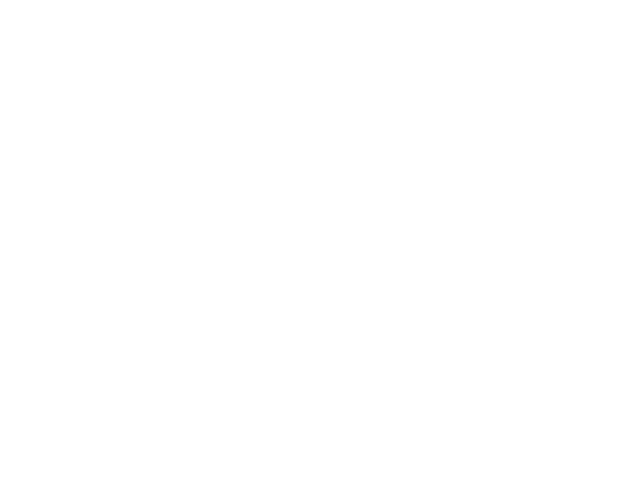

No handles with labels found to put in legend.


In [47]:
batch_plot_by_id(range(1501,1501+1), marker = '.', ls = '')

tfsstb = 1

better, but do we need that R at all? Keithley is a current source.. 

<IPython.core.display.Javascript object>


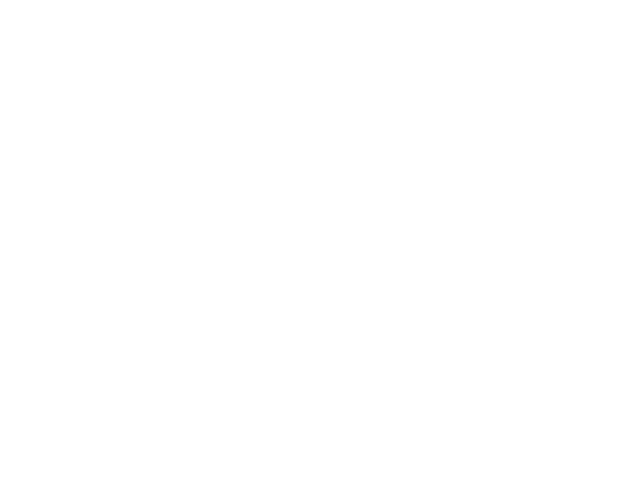

No handles with labels found to put in legend.


In [48]:
batch_plot_by_id(range(1502,1502+1), marker = '.', ls = '')

Put 1 MhOm only, 0.1 timedelay

<IPython.core.display.Javascript object>


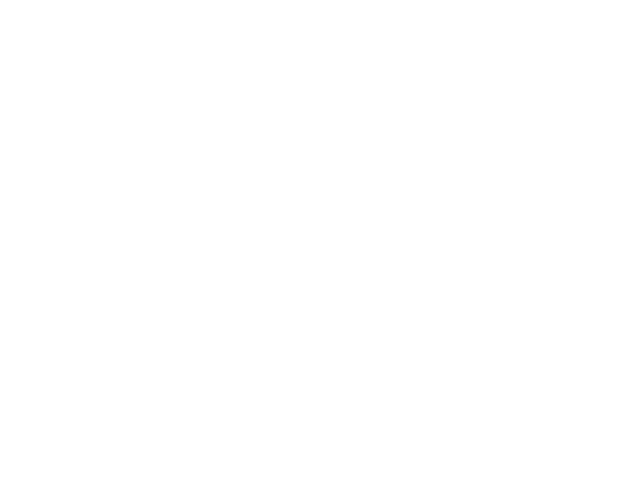

No handles with labels found to put in legend.


In [49]:
batch_plot_by_id(range(1504,1505+1), marker = '.', ls = '')

Yay, works! Question is how to change ranges(now .1nA is limit)

<IPython.core.display.Javascript object>


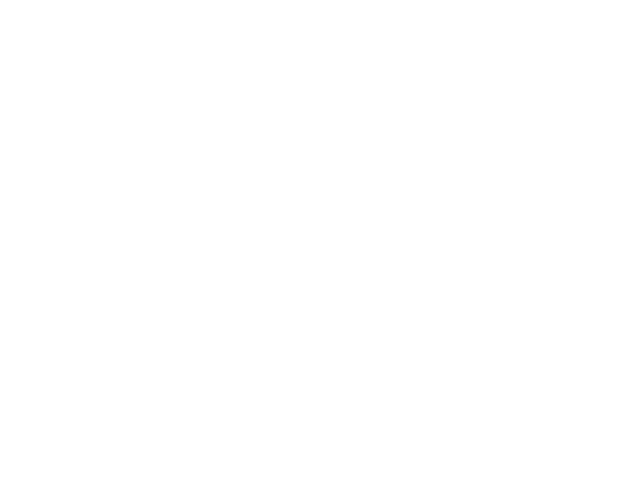

No handles with labels found to put in legend.


In [50]:
# IVC for cos = np.linspace(.15, 0, 7)
batch_plot_by_id(range(1506,1512+1), marker = '.', ls = '-')

#### Low cos with Keith
    

<IPython.core.display.Javascript object>


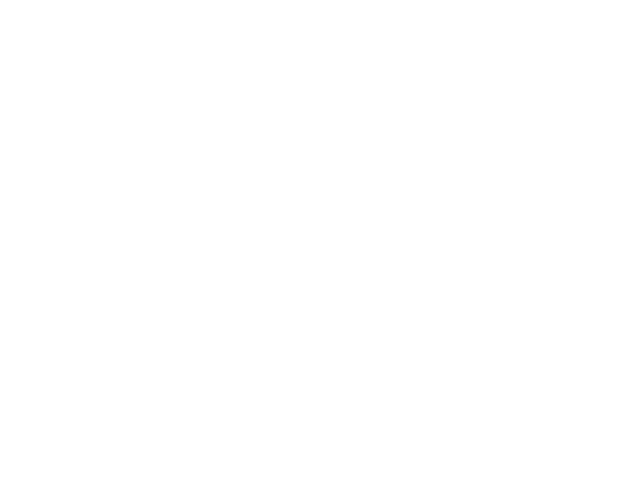

No handles with labels found to put in legend.


In [51]:
# Reminder - AWG
batch_plot_by_id(range(1472,1478+1), marker = '.', ls = '-')

hm, what anout fast 4? (and .02 nA stepsize - changed range manually)


<IPython.core.display.Javascript object>


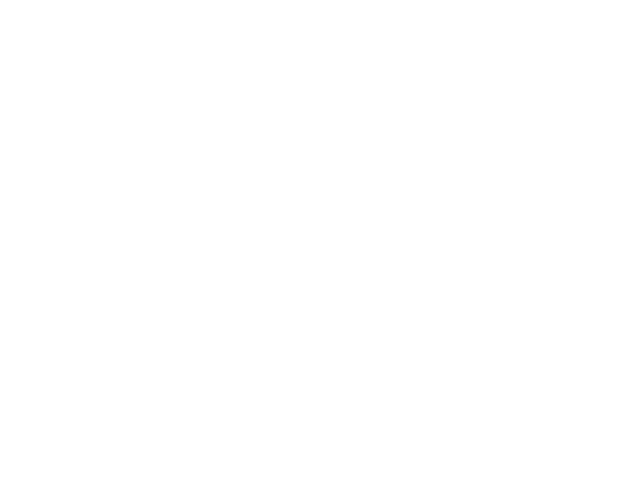

No handles with labels found to put in legend.


In [52]:
batch_plot_by_id(range(1514,1520+1), marker = '.', ls = '-')

Compare AWG and Keithley at cos = .15

<IPython.core.display.Javascript object>


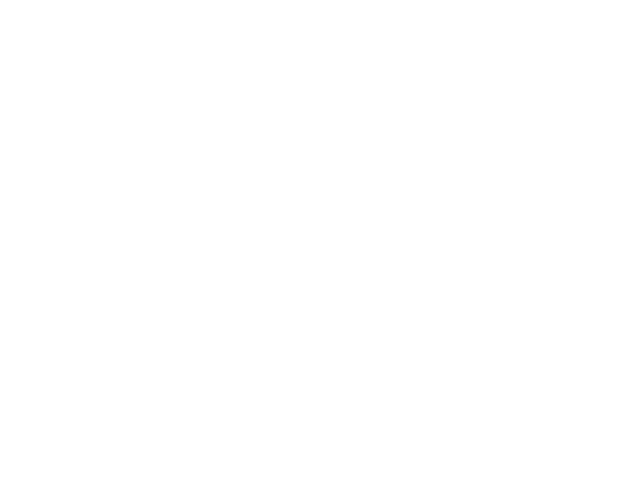

No handles with labels found to put in legend.


In [53]:
i = 3
batch_plot_by_id([1514+i, 1472+i], marker = '.', ls = '-')

Looks smoother, but is it effect of noise? try fast 6 (or value of ext rtesistor drives the system to the overdamped regime??)

same as fast 4

<IPython.core.display.Javascript object>


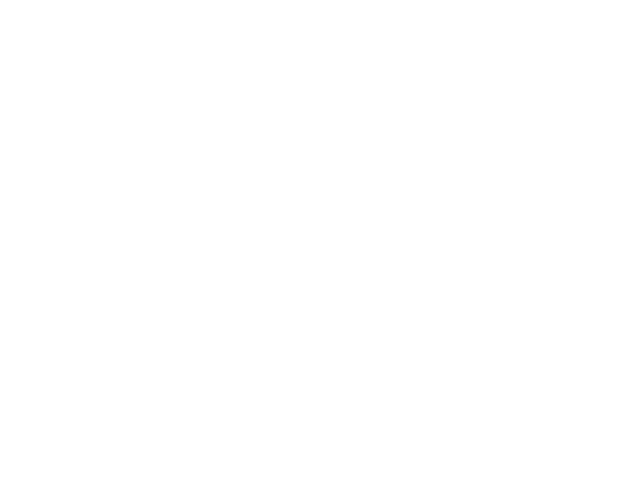

No handles with labels found to put in legend.


In [54]:
batch_plot_by_id([1521, 1514], marker = '.', ls= '-')

IVC for Keisley in deff regimes (1e-6 vs 1e-7):


<IPython.core.display.Javascript object>


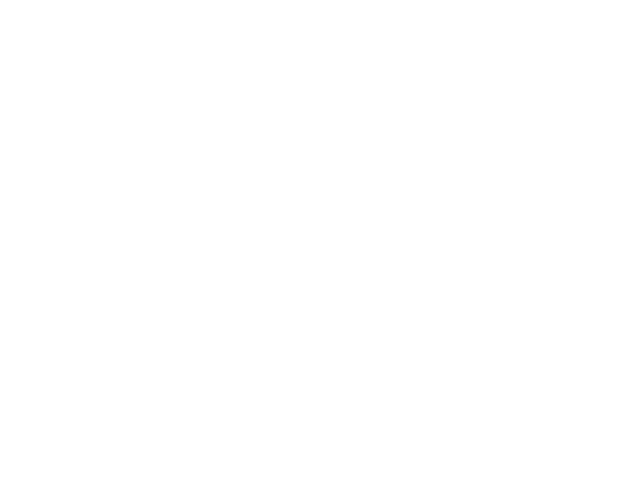

No handles with labels found to put in legend.


In [55]:
i = 1
batch_plot_by_id([1506+i, 1514+i], marker = '.', ls = '-')

Ok, put 10MOhm

<IPython.core.display.Javascript object>


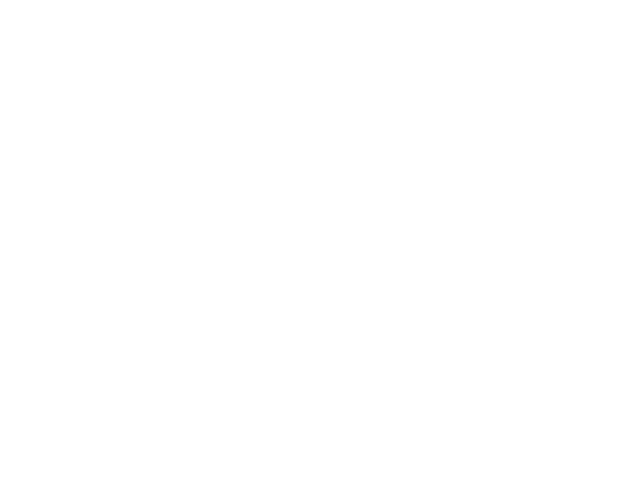

No handles with labels found to put in legend.


In [56]:
i = 0
batch_plot_by_id([1524+i, 1514+i], marker = '.', ls = '-')

Hm! Put just short (50 ohm) vs 1MOhm

<IPython.core.display.Javascript object>


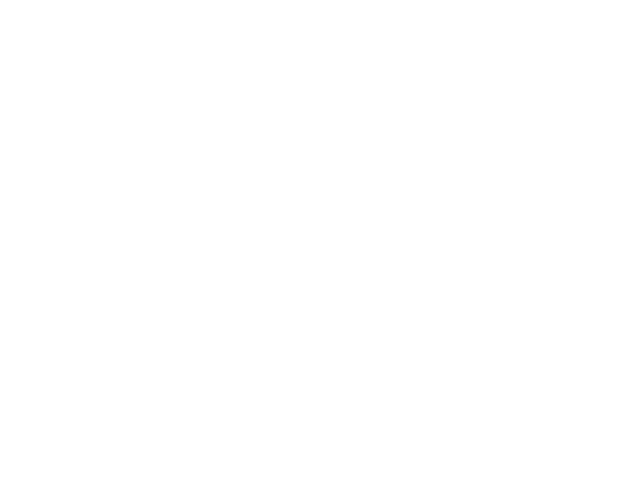

No handles with labels found to put in legend.


In [57]:
batch_plot_by_id([1530, 1514], marker = '.', ls = '')

#### IVC with diiferent Rload
    have to use tfsstb = 2 since RC cutoff changes with R (even 10 for 100Mohm)

<IPython.core.display.Javascript object>


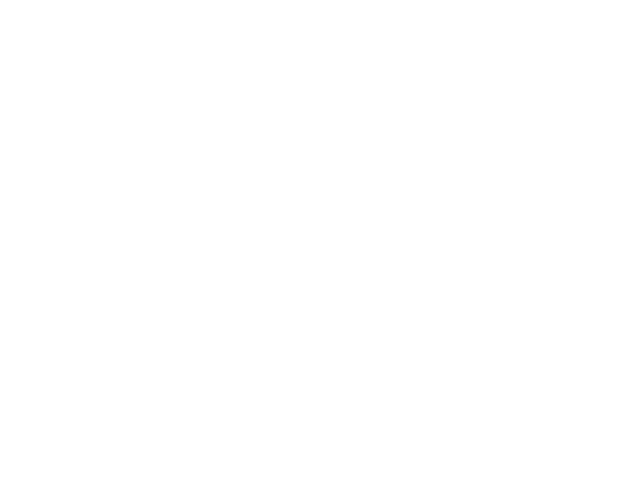

In [58]:
labels = ['100 MOhm', '10 MOhm', '1 MOhm', '500 kOhm', 'short']
batch_plot_by_id([1535, 1536, 1538, 1539, 1540],
                 labels = labels, marker = '.', ls = '-')

100 MOhm for 2 and 10 s

<IPython.core.display.Javascript object>


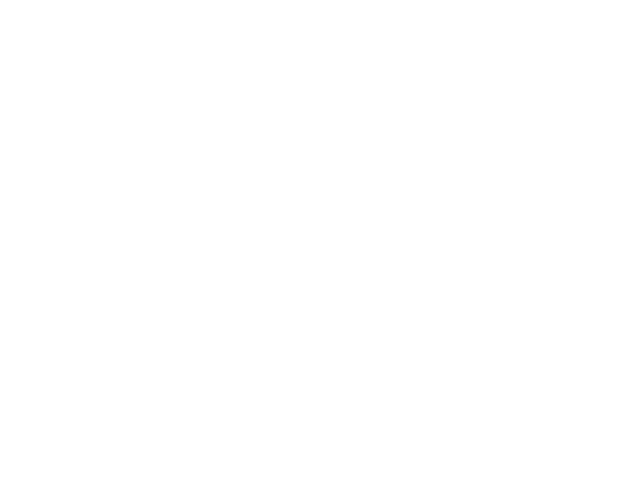

In [59]:
labels = ['10 s', '2s']
batch_plot_by_id([1541, 1542],
                labels = labels, marker = '.', ls = '-')

Doesnt depend on time delay? Ok, repeat 10 MOhm 

<IPython.core.display.Javascript object>


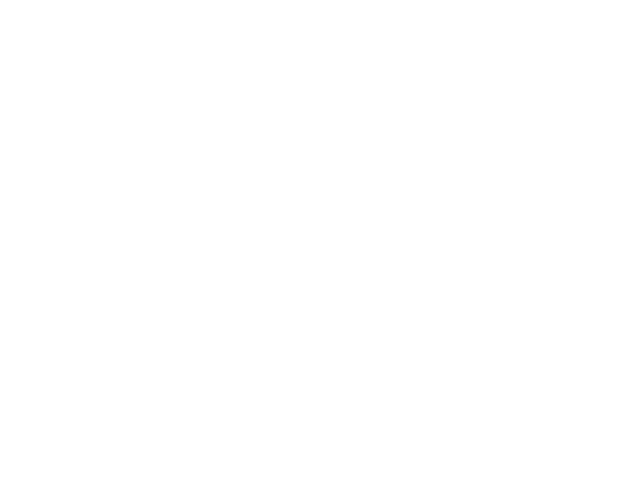

In [60]:
labels = ['first try', 'second try']
batch_plot_by_id([1536, 1543],
                labels = labels, marker = '.', ls = '-')

WTF! Remeas everything

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


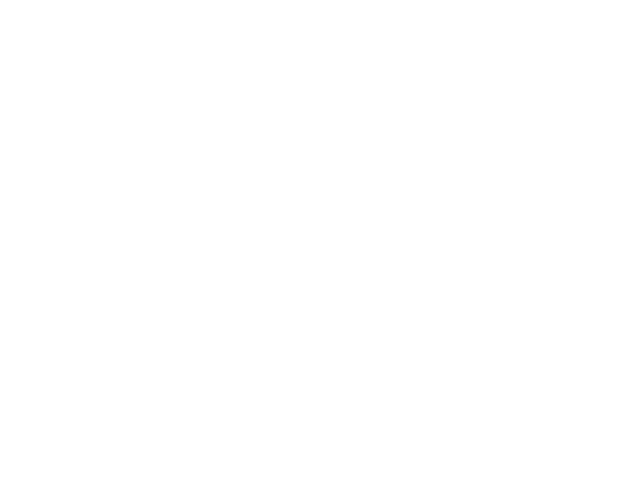

In [61]:
labels = ['100 MOhm', '10 MOhm', '1 MOhm', '100 kOhm', 'short']
batch_plot_by_id([1541, 1543, 1553, 1554, 1555],
                 labels = labels, marker = '.', ls = '-')

somewhat random changes of IVc. or just supression of Isw?
remeas with tfsstb = .1, di = 0.02nA

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


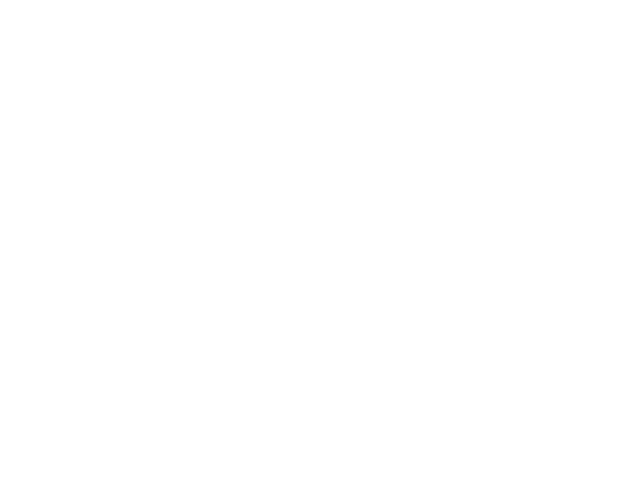

In [62]:
labels = [ '100 MOhm','10 MOhm','1 MOhm','100 kOhm', 'short' ]
batch_plot_by_id([1560, 1559, 1558,1557, 1556],
                 labels = labels, marker = '.', ls = '-')

1. subgap structure for lowest Rload? meas more carefully with fast 6

<IPython.core.display.Javascript object>


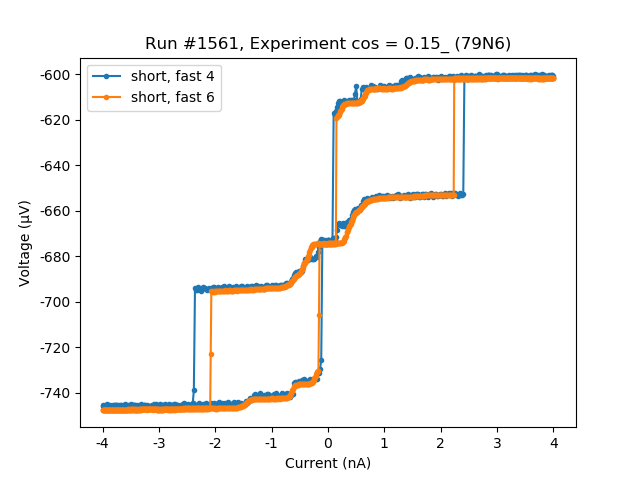

In [84]:
labels = [ 'short, fast 4', 'short, fast 6' ]
batch_plot_by_id([1556, 1561],
                 labels = labels, marker = '.', ls = '-')

ah, may be this is just noise and we should meas everything with fast 6?
no, it was indeed earler jump at fast4. also there are ''near-gap' and 'near supercurrent' states - what's that??

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


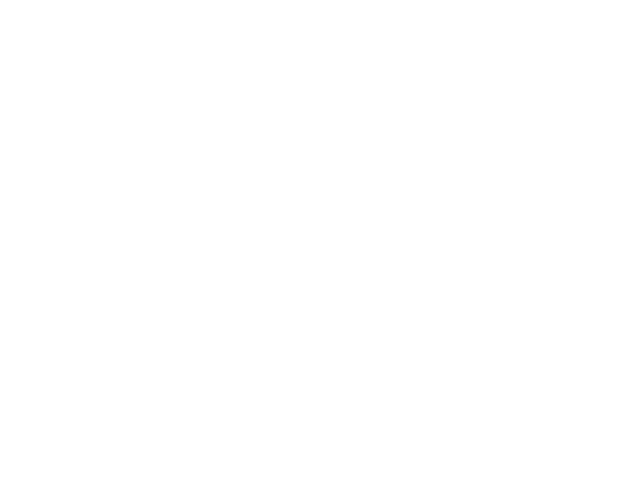

In [64]:
labels = [ 'short, fast 4', 'short, fast 6' ]
batch_plot_by_id([1557, 1562],
                 labels = labels, marker = '.', ls = '-')

Ok, what if we just open box, shunt, remove Rload, put back, close - would we get the same IVc?

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


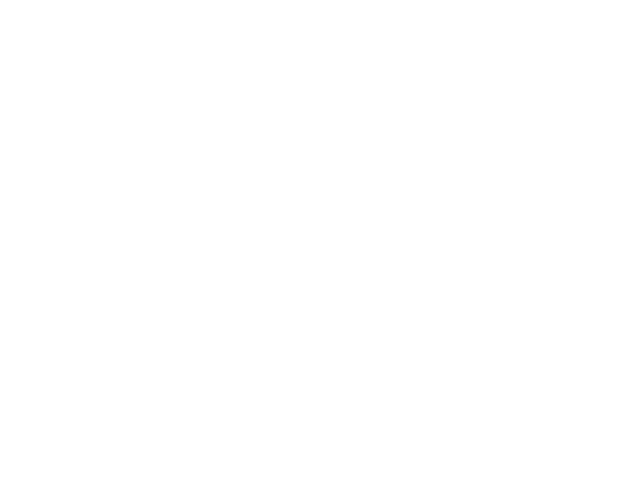

In [65]:
labels = [ '100 kOhm, fast 6', '1 min later',
          '~5 min later', '~10 min later' ]


batch_plot_by_id([1562, 1563, 1564, 1565],
                 labels = labels, marker = '.', ls = '-')

Repeat short (50 Ohm actually)

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


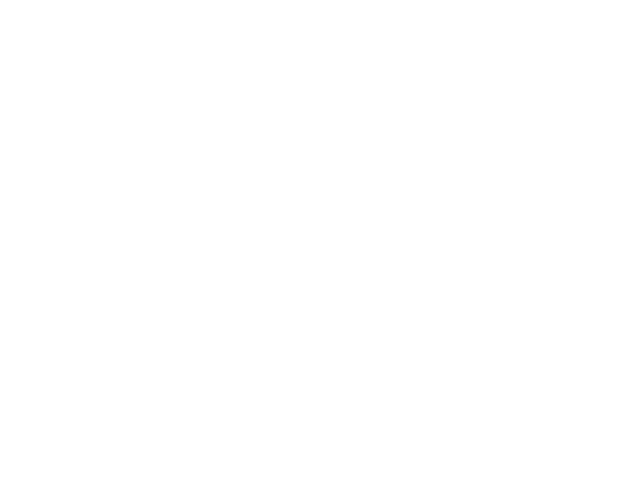

In [66]:
labels = [ 'short, fast 6', '~ half-hour before' ,'' ]


batch_plot_by_id([1566, 1561,1566],
                 labels = labels, marker = '.', ls = '-')

# 12/18 kk
    Cheched and fixed ground loops.
    Plan for today :
    - does ground loop help?
    - keep playing with Kei, how reproducable IVC are
    - AWG with different Rload, same stepsize
    

## full IVC check
    Rload = 50 Ohm

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


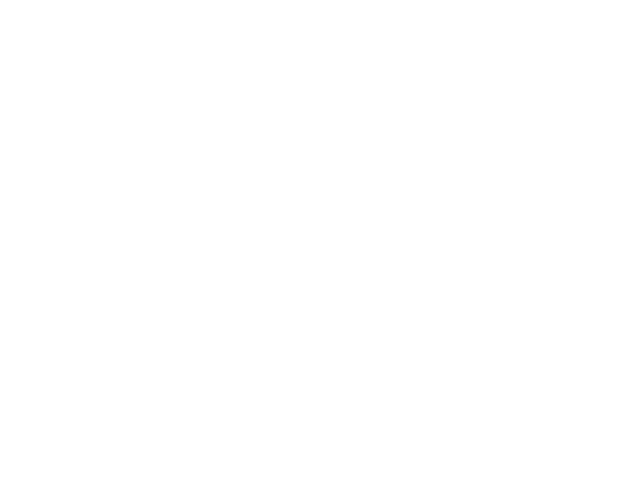

No handles with labels found to put in legend.


In [67]:
batch_plot_by_id([1580,1581,1582,1583], marker = '.', ls = '-')

Drift in the battery baised pre-amp, switch to line

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


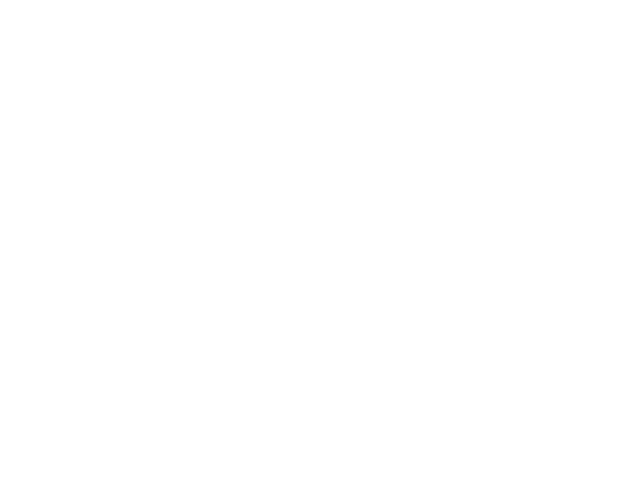

In [68]:
ls = ['cos = 1', 'cos = .15']

batch_plot_by_id([1585,1587], 
                 labels = ls, marker = '.', ls = '-')

Meas 50 Ohm, cos = .15 just several times in raw

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


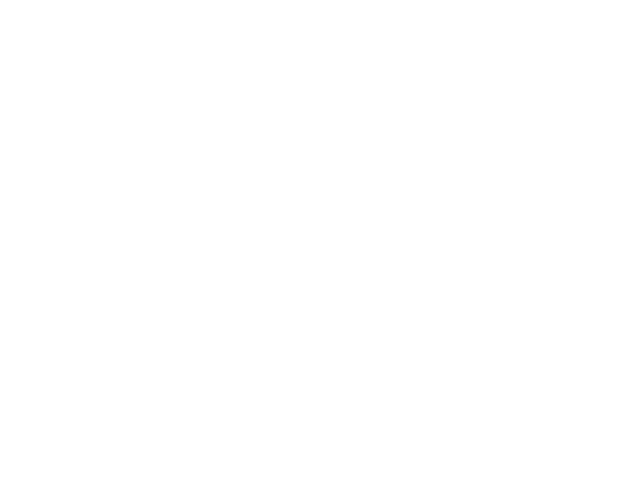

In [69]:
fig, ax = plt.subplots()
ls = '','line power', ''
batch_plot_by_id([1587, 1589, 1590], ax = ax, labels = ls, 
                  marker = '.', ls = '-')

ax2 = ax.twinx()
ls = 'batt power (yesterday)'
batch_plot_by_id([ 1566], ax = ax2, labels = ls,
                  marker = '.', ls = '-')

Big step at 66uV
Sub-steps at 61.5, 55.1, 49?, .., 14, 2.2

Now it's more nnoisy? try open--disconnect-connect-close cycle

No, just a shift of level (why?) ws: preamp drifts?

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


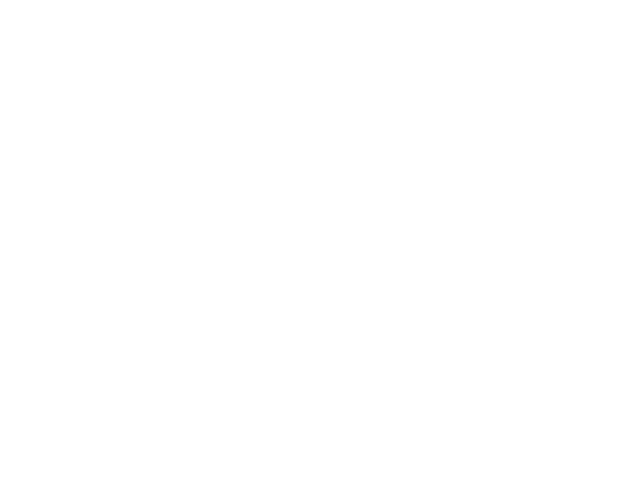

In [70]:
fig, ax = plt.subplots()
ls = 'before','after', ''
batch_plot_by_id([ 1590, 1591], ax = ax, labels = ls, 
                  marker = '.', ls = '-')

let's try different Rload again?

no much difference. but now preamp is power-lined, so the door is open, more noise?

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


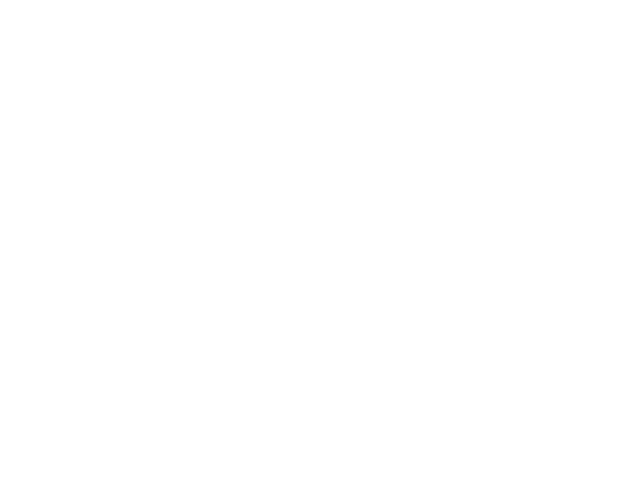

In [71]:
labels = '50 Ohm', '100 kOhm','1 MOhm'# [ '100 MOhm','10 MOhm','1 MOhm','100 kOhm', 'short' ]
batch_plot_by_id([1590, 1592, 1593],
                 labels = labels, marker = '.', ls = '-')

Put 50 Ohm back, change Keith setting (output low -> gnd)

that just introduced 50uv offset, and V meas are more noisy

<IPython.core.display.Javascript object>


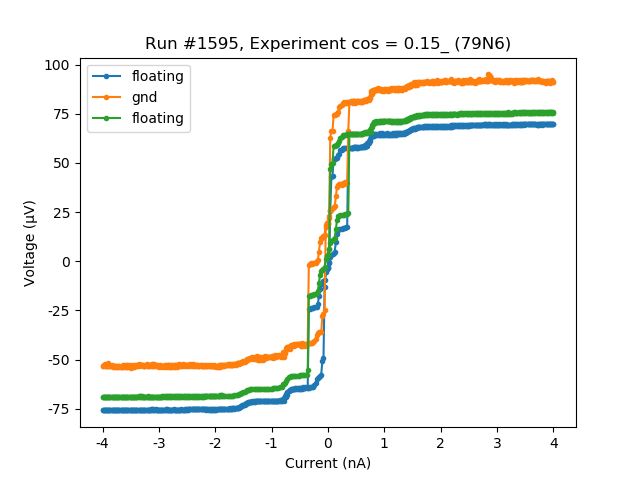

In [85]:
labels = 'floating', 'gnd','floating'
batch_plot_by_id([1590, 1594,1595],
                 labels = labels, marker = '.', ls = '-')

Why it's so noisy? battery is not fully charged yet, but quick test if closing a door helps

Hm, noise is defenetly lower, but there is still high R0

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


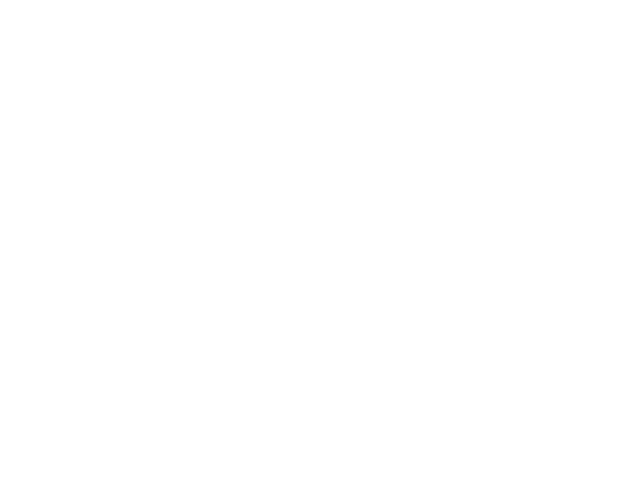

In [73]:
labels = 'line', 'batt'
batch_plot_by_id([1590, 1597],
                 labels = labels, marker = '.', ls = '-')

Swith to AWG, battery

bueh

<IPython.core.display.Javascript object>


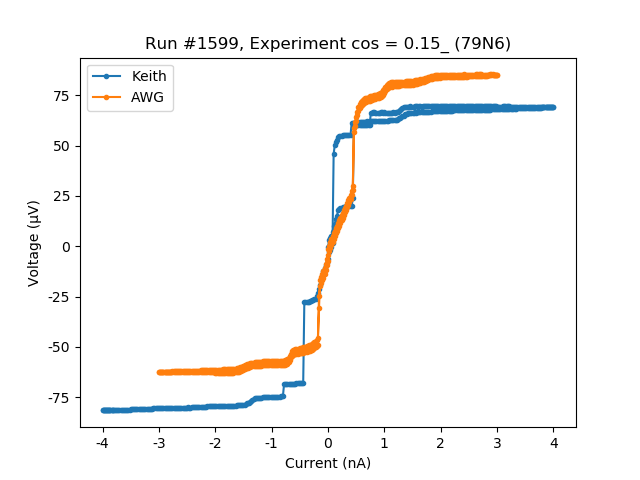

In [86]:
labels = 'Keith', 'AWG'
batch_plot_by_id([1597, 1599],
                 labels = labels, marker = '.', ls = '-')

change the imput impedance 

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


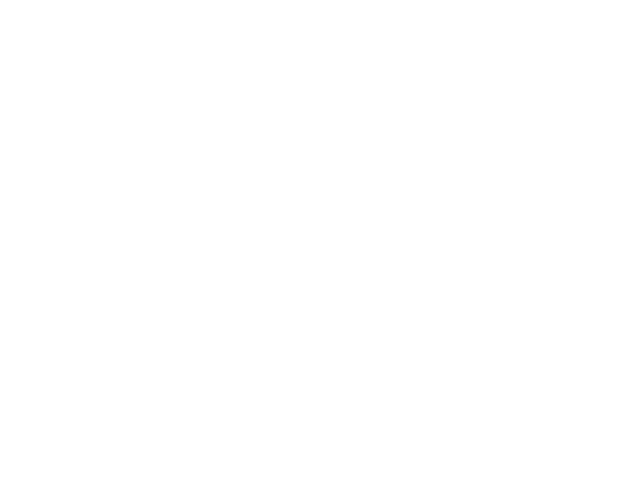

In [75]:
labels = '10 MOhm', '10 GOhm'
batch_plot_by_id([1597, 1601],
                 labels = labels, marker = '.', ls = '-')

Meas cos = np.linspace(.15, .0, 7), battery, Keithley, 50 Ohm

<IPython.core.display.Javascript object>


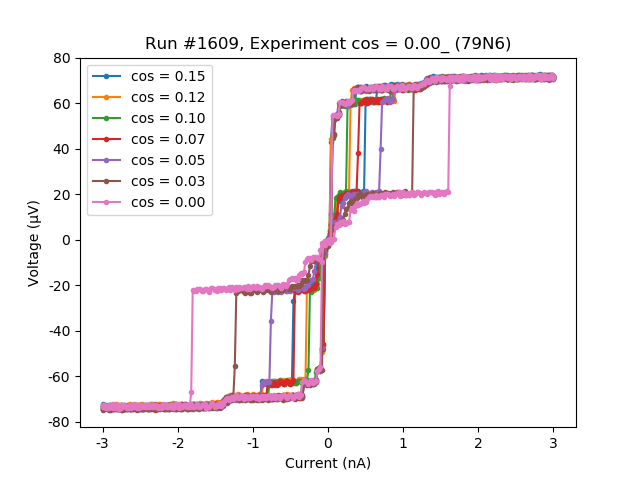

In [128]:
labels = [ 'cos = {:1.2f}'.format(cos) for cos in np.linspace(.15,0,7)]
batch_plot_by_id(range(1603,1609+1),
                 labels =labels, marker = '.', ls = '-')

So it look like ZF value has been shifted, so we should remeasure period, ZF and FF

but note how amazing pink curve is, so many steps!

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


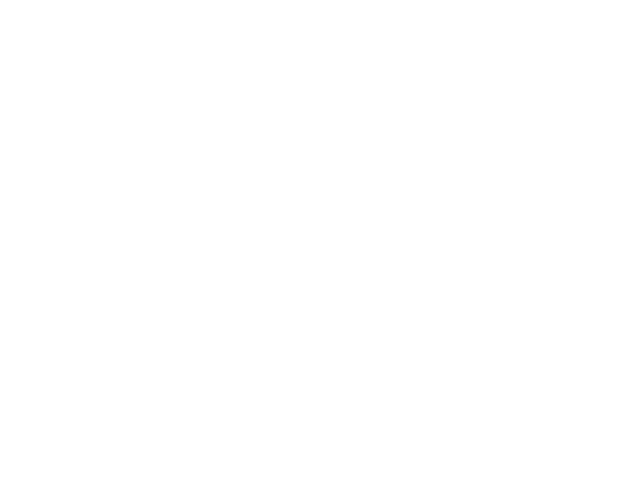

No handles with labels found to put in legend.


In [77]:
batch_plot_by_id([1609,1610, 1614, 1615, 1616],
                 marker = '.', ls = '-')

just check if we can measure this fine structure on the line-powered pre-amp

<IPython.core.display.Javascript object>


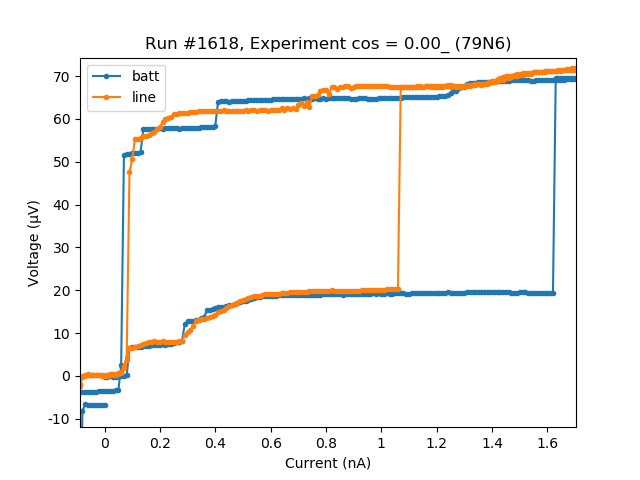

In [127]:
labels = 'batt', 'line'
batch_plot_by_id([1615, 1618],
                 labels =labels, marker = '.', ls = '-')

## Periodicity check

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


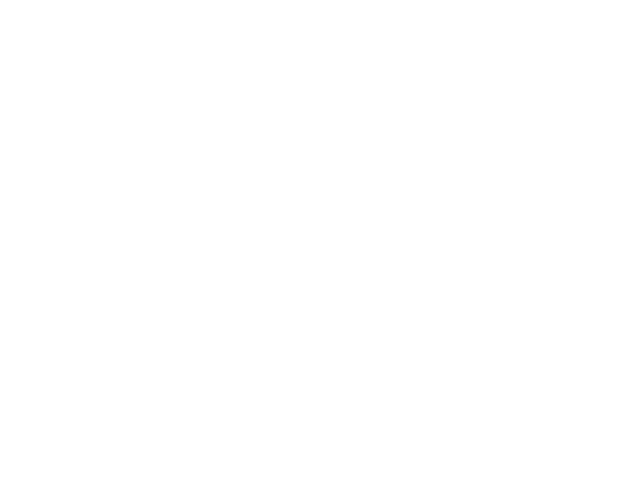

No handles with labels found to put in legend.


In [79]:
batch_plot_by_id(range(1625,1639+1),
                  marker = '.', ls = '-')

In [80]:
keys = [ 'ids', 'T',    'B',  'comments'        ] 

valss =[
      [range(1625,1656+1),  45e-3, np.linspace(0, 620e-6, 32), 'IVc vs B'  ],
#        [range(1662,1675+1),  45e-3,cos_to_B(np.append(np.linspace(0.150, 0.0,7),np.linspace(0.30, 0.15,7))), 'IVc vs B'  ]]
[range(1687,1675+1),  45e-3, np.linspace(215e-6, 245e-6, 11), 'IVc vs B'  ]]



exps = [{ key : val for key, val in zip(keys, vals)  }  for vals in valss ]


populate_exps (exps, VERBOSE = False)

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\KelvinOX25\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


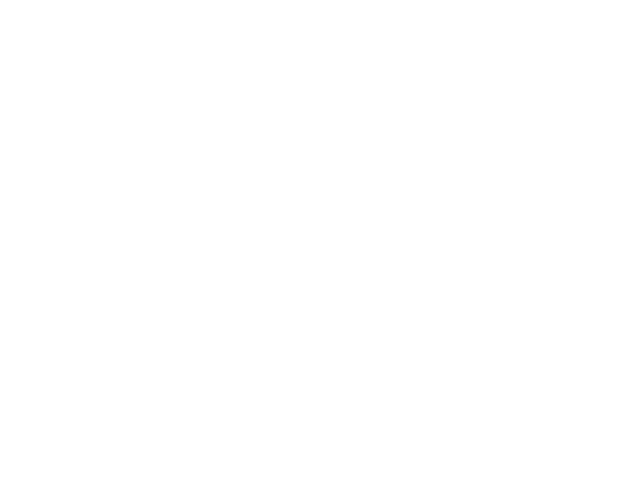

ValueError: x and y must have same first dimension, but have shapes (11,) and (0,)

In [81]:
fig, ax = plt.subplots()

exp = exps[-1]

ax.plot(exp ['B' ] , exp['Isws'], 'o-', label = 'Isw')
# ax.set_yscale('log')

ax.legend()


Updated ZF and FF (check again?)??

ff = 230
2*zf = 460
df = 230
zf = 0 ??

In [ ]:
460-230

In [ ]:
fig, ax = plt.subplots()

exp = exps[0]

ax.plot(exp ['cos' ] , exp['Isws'], 'o-', label = 'Isw')

ax.legend()


## Repeat cos = .15 - 0

In [ ]:
labels = [ 'cos = {:1.2f}'.format(cos) for cos in np.linspace(.15,0,7)]
batch_plot_by_id(range(1662,1668+1),
                  labels = labels, marker = '.', ls = '-')

In [ ]:
labels = [ 'cos = {:1.2f}'.format(cos) for cos in np.linspace(.3,0.15,7)]
batch_plot_by_id(range(1669,1675+1),
                  labels = labels, marker = '.', ls = '-')

## histograms for small cos

check of high res (1pA), works fine

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\dataset\plotting.py:196: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, **subplots_kwargs)


<IPython.core.display.Javascript object>


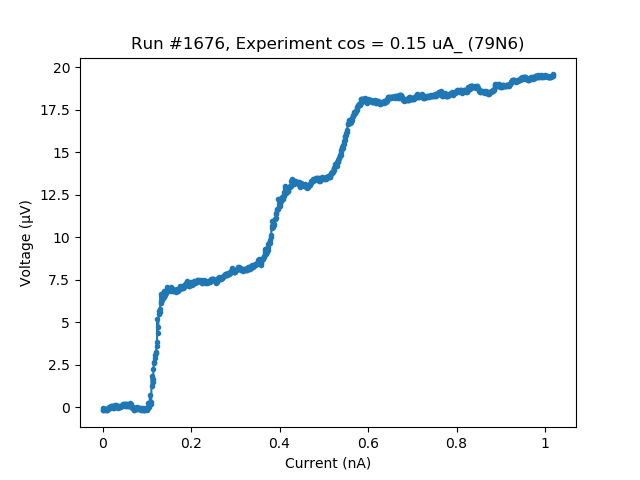

([<matplotlib.axes._subplots.AxesSubplot at 0xba5d110>], [None])

In [82]:
plot_by_id(1676,marker ='.')

measuring histograms for cos =.1 -.25 with 2 pA res, to see if we have ta-udp transition. from ivcs it seems like we have  sharp jump (stochastic) for all small Ic values

In [ ]:
plot_by_id(1681)

In [ ]:
fig, ax = plt.subplots()


for idx in range(1677,1681+1):
    plot_hist_by_id(idx, ax=ax)
    Ic0, Teff = fit_hist_by_id(idx, EJ = 2, Ec = 0.05, bins=31)
    
    print(Ic0, Teff )


<IPython.core.display.Javascript object>


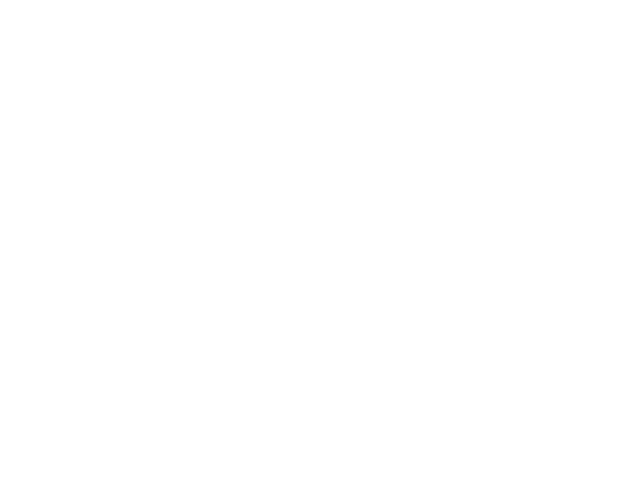

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


In [87]:
Ic0lst = []
Tefflst = []
coslst = np.linspace(.1,0.2,5)
#,labels = 'cos = {:1.2f}'.format(coslst[a])

plt.close('all')
f,ax = plt.subplots(3,1)
for a,i in enumerate(range(1677,1680+1)):
    Ic = get_data_by_id(i)[0][1]['data']
    ax[0].hist(Ic,bins=int(np.sqrt(len(Ic))))
    Ic0, Teff = fit_hist_by_id(i, EJ = 2, Ec = 0.05, bins=int(np.sqrt(len(Ic))))
    Ic0lst.append(Ic0)
    Tefflst.append(Teff)
# ax[1].plot(coslst, Ic0lst)
# ax[2].plot(coslst, Tefflst)
plt.show()

# 12/19 kk

Check IVc for line and batt:

Line is better!!!

<IPython.core.display.Javascript object>


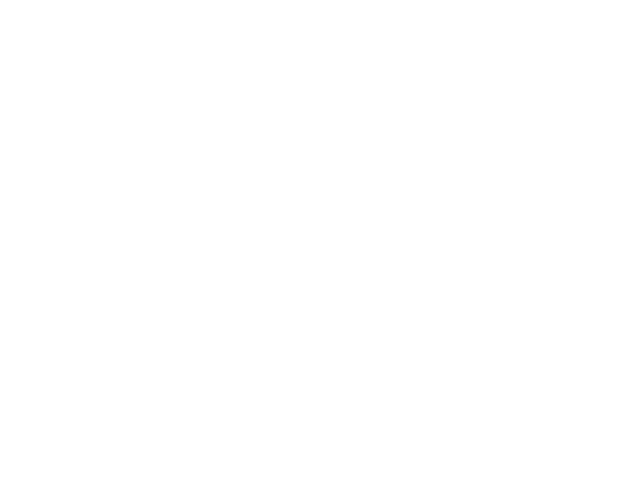

In [88]:
labels = 'line', 'batt', 'batt again', 'line again'
batch_plot_by_id([1682, 1683, 1684, 1685],
                 labels =labels, marker = '.', ls = '-')

Also check of periodicity: meas cos .15 and -.15

<IPython.core.display.Javascript object>


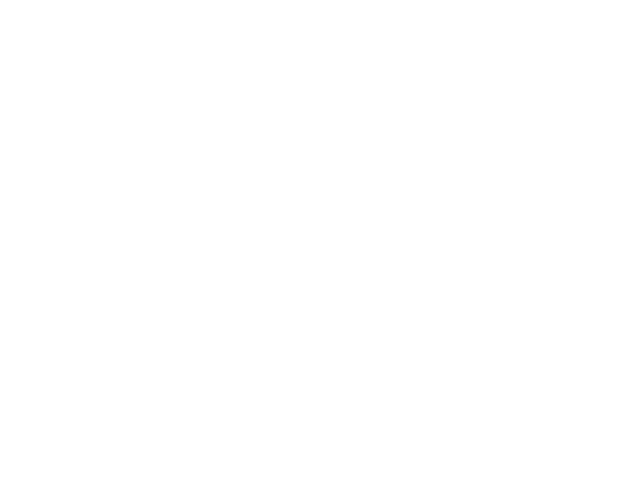

In [89]:
labels = 'cos =.15', 'cos = -.15'
batch_plot_by_id([1685, 1686],
                 labels =labels, marker = '.', ls = '-')

## Preiodicity

finer B scan for periodicity

<IPython.core.display.Javascript object>


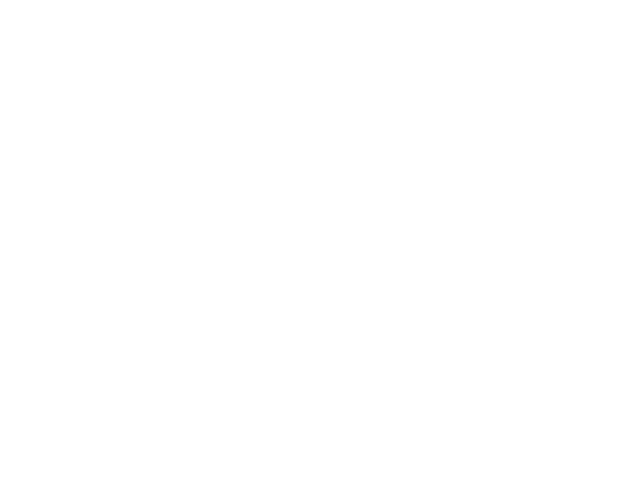

No handles with labels found to put in legend.


In [90]:
batch_plot_by_id(range(1687, 1692+1),
                  marker = '.', ls = '-')

In [91]:
keys = [ 'ids', 'T',    'B',  'comments'        ] 

valss =[
      [range(1625,1656+1),  45e-3, np.linspace(0, 620e-6, 32), 'IVc vs B'  ],
#        [range(1662,1675+1),  45e-3,cos_to_B(np.append(np.linspace(0.150, 0.0,7),np.linspace(0.30, 0.15,7))), 'IVc vs B'  ]]
[range(1687,1697+1),  45e-3, np.linspace(215e-6, 245e-6, 11), 'IVc vs B'  ]]



exps = [{ key : val for key, val in zip(keys, vals)  }  for vals in valss ]


populate_exps (exps, VERBOSE = False, ZF_ = .00e-3, FF_ = .227e-3,)

<IPython.core.display.Javascript object>


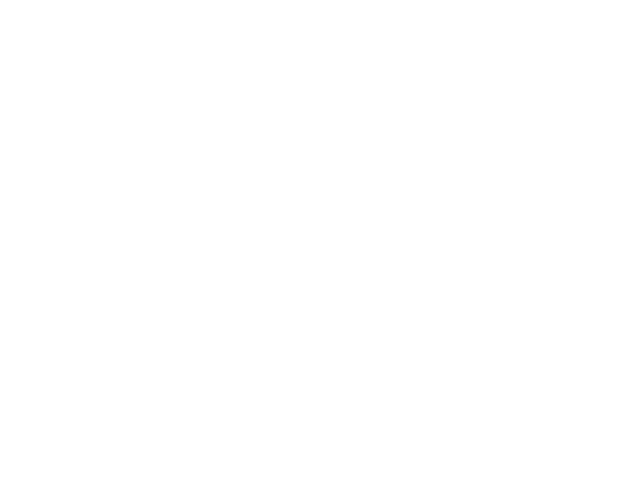

In [92]:
fig, ax = plt.subplots()

exp = exps[0]

ax.plot(exp ['B' ] , exp['Isws'], 'o-', label = 'Isw')

ax.legend()

Updated ZF = 0, FF = 227

## AWG check


<IPython.core.display.Javascript object>


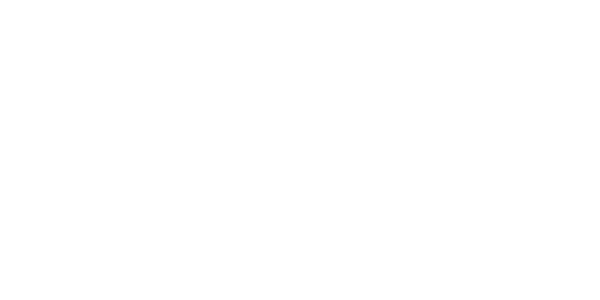

In [93]:
f,ax=plt.subplots(1,1, figsize = (6,3))

labels = 'KE','AWG 100MOhm', 'AWG 1GOhm' 
batch_plot_by_id([1704,1706, 1708],
                 labels = labels, 
                 marker = 'x', ls = '-',
                ax = ax)

check keith diff ranges

<IPython.core.display.Javascript object>


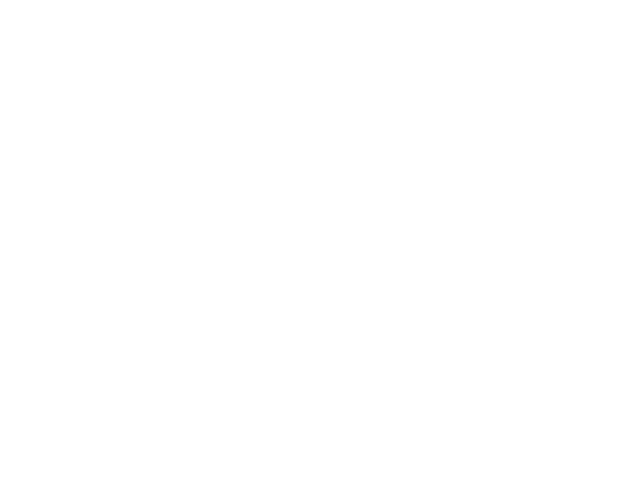

In [94]:
labels = '2pA, 1e-8', '20pA, 1e-7'
batch_plot_by_id([1718, 1719],
                 labels =labels, marker = '.', ls = '-')

<IPython.core.display.Javascript object>


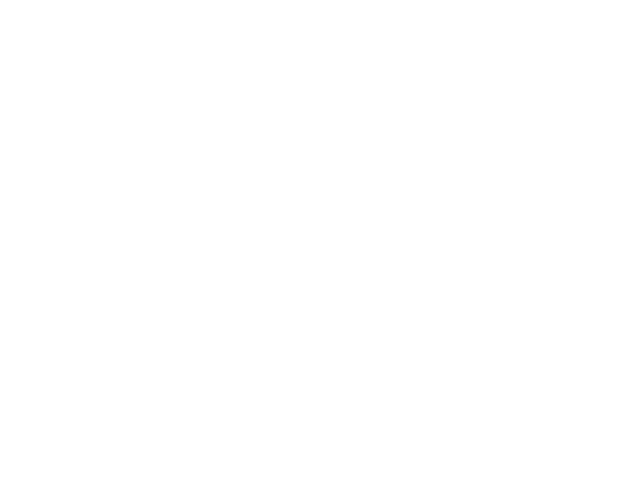

([<matplotlib.axes._subplots.AxesSubplot at 0xa3ec490>], [None])

In [95]:
plot_by_id(1724, marker = '.', ls = '')

No issues with Keith.. Dunno what to measure more, switch to chain N5 now

# WS

### 12/16

<IPython.core.display.Javascript object>


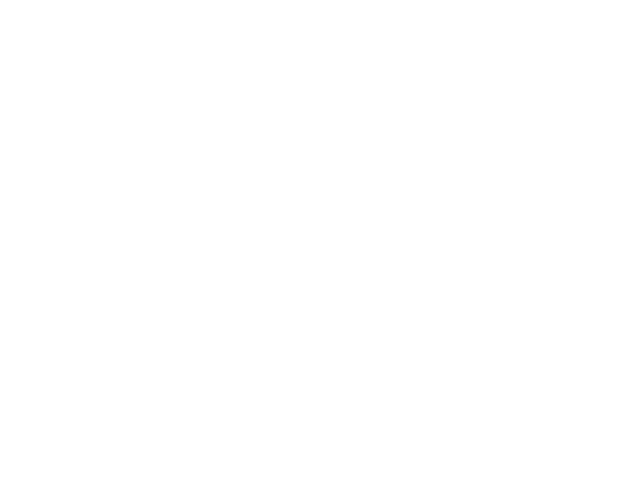

In [96]:
plt.close('all')
f,ax = plt.subplots()
for i in range(1443,1444+1):
    ax.hist(get_data_by_id(i)[0][1]['data'],bins=int(np.sqrt(len(Ic))))
plt.show()

In [97]:
def cos_to_B(cos):
    FF_ = .232e-3
    ZF_ = .004e-3
    return np.arccos( cos)*(2* (FF_ - ZF_)/np.pi + ZF_  )

<IPython.core.display.Javascript object>


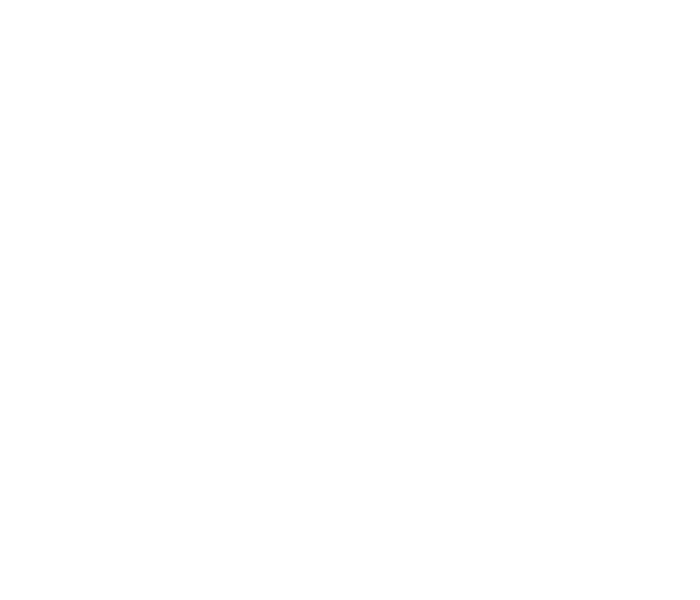

In [98]:
plt.close('all')
f,ax=plt.subplots(2,2, figsize=(7,6))
ax = ax.flatten()

Iclstp = np.asarray([])
Blst = np.linspace(ZF, ZF + 1.0*dF, 51)
for i,v in enumerate(range(763,813+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)):
        if abs(w) > 1e-4:
            Iclstp = np.append(Iclstp,np.abs(Is[j]))
            break
ax[1].plot(np.cos(Blst/FF*np.pi/2), Iclstp, '.', ls='-', label = 'by single IVc')

Iclstp = np.asarray([])
Blst = cos_to_B(np.linspace(0.4,-0.4,9))
for i,v in enumerate(range(1458,1466+1)):#range(1458,1466+1) 1468,1458,
    data = get_data_by_id(v)
    Is = data[0][0]['data'][9:]
    Vs = data[0][1]['data']-data[0][1]['data'][-1]-0.28e-3
    Vs = Vs[9:]
    ax[0].plot(Is,Vs,ls='-',marker='.')
    for j,w in enumerate(np.diff(Vs)):
        if abs(w) > 1.5e-5:
            Iclstp = np.append(Iclstp,np.abs(Is[j]))
            break
            
ax[1].plot(np.linspace(0.3,-0.3,7), Iclstp[1:-1], '.', ls='-', label = 'by single IVc')
Blst = np.linspace(ZF, ZF + 2.0*dF, 51)
ax[1].plot(np.cos(Blst/FF*np.pi/2),148.8e-9*np.abs(np.cos(Blst/FF*np.pi/2)),'--', label = '$I_{AB}*cos(B)$')

Iclst = []
for i in range(1443,1456+1):
    Ic = get_data_by_id(i)[0][1]['data']
    Iclst.append(Ic.mean())
ax[1].plot(np.asarray([np.linspace(1.0,0.4,7), np.linspace(-0.4,-1.0,7)]).flatten(), Iclst,'.', label = 'by hist.')

ax[1].legend()
ax[1].grid()
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))
plt.tight_layout()
plt.show()


for i in range(1443,1456+1):
    Ic = get_data_by_id(i)[0][1]['data']
    ax[2].hist(Ic,bins=int(np.sqrt(len(Ic))))

<IPython.core.display.Javascript object>


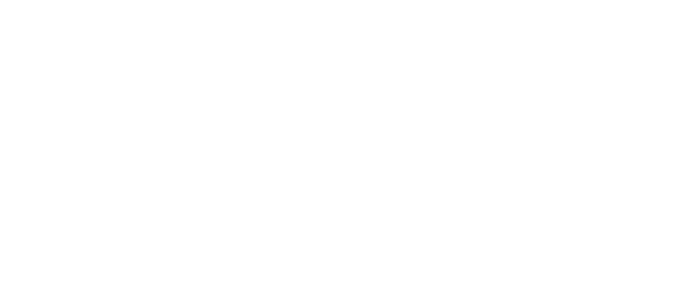

In [99]:
SAMPLE = '79N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))
ax = ax.flatten()

label = ['KE', 'AWG', 'KE+delay', 'AWG','','']
for i,v in enumerate([1397,1398, 1399, 1400]):#fast 4, fast
    data = get_data_by_id(v)
    Ic = data[0][1]['data']
    ax[0].hist(Ic, bins=int(np.sqrt(len(Ic))), label = label[i], alpha = 0.9)

ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$try (\#)$')
ax[0].set_title('2.2x1.7 SQUID 1x,\n Vsrc type', pad=10)
ax[0].grid()
ax[0].legend()
# ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

label =  range(0,35,5)
for i,v in enumerate(range(1408,1414+1)):#fast 4, fast 1401,1407+1
    data = get_data_by_id(v)
    Ic = data[0][1]['data']
    ax[1].hist(Ic, bins=int(np.sqrt(len(Ic))), label = label[i], alpha = 1)

ax[1].set_xlabel('$I (A)$')
ax[1].set_ylabel('$try (\#)$')
ax[1].set_title('2.2x1.7 SQUID 1x,\n AWG scan t-delay', pad=10)
# ax[1].set_ylim(0,5)
ax[1].grid()
ax[1].legend()
# ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

### 12/17

<IPython.core.display.Javascript object>


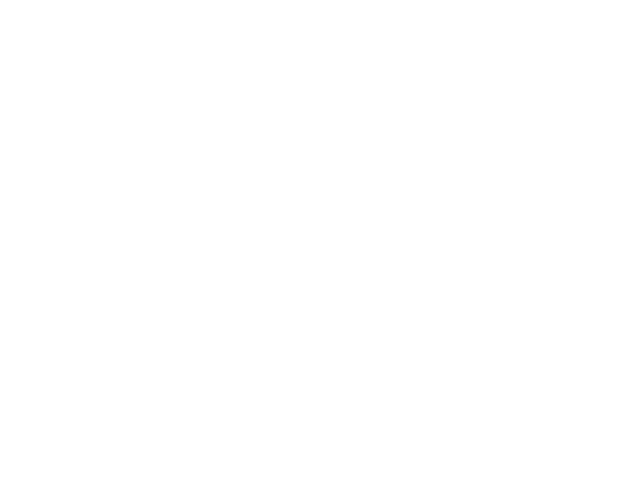

In [100]:
#fast 6
plt.close('all')
f,ax = plt.subplots()
for i in range(1566,1569+1):
    ax.plot(get_data_by_id(i)[0][0]['data'],
            get_data_by_id(i)[0][1]['data'], '-')
plt.show()

<IPython.core.display.Javascript object>


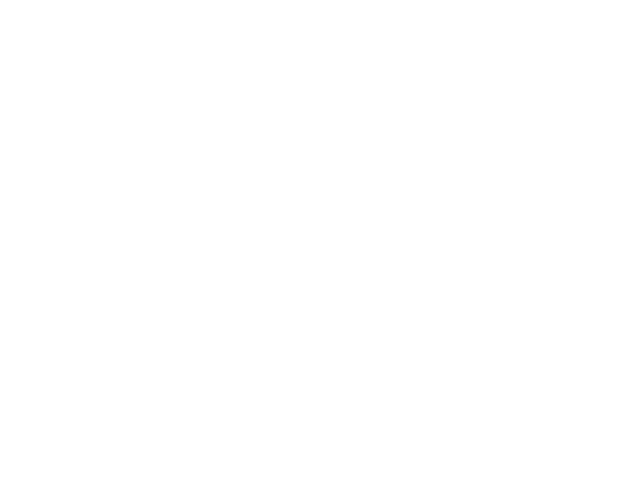

In [101]:
#fast 4
plt.close('all')
f,ax = plt.subplots()
for i in range(1570,1572+1):
    ax.plot(get_data_by_id(i)[0][0]['data'],
            get_data_by_id(i)[0][1]['data'], '-')
plt.show()

In [102]:
data = get_data_by_id(v)
len(data[0][1]['data'])

100

<IPython.core.display.Javascript object>


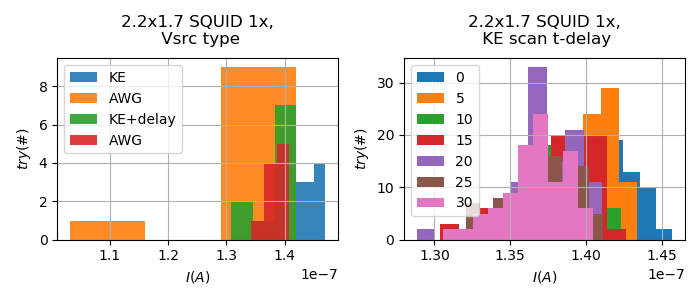

In [110]:
SAMPLE = '79N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))
ax = ax.flatten()

label = ['KE', 'AWG', 'KE+delay', 'AWG','','']
for i,v in enumerate([1397,1398, 1399, 1400]):#fast 4, fast
    data = get_data_by_id(v)
    Ic = data[0][1]['data']
    ax[0].hist(Ic, bins=int(np.sqrt(len(Ic))), label = label[i], alpha = 0.9)

ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$try (\#)$')
ax[0].set_title('2.2x1.7 SQUID 1x,\n Vsrc type', pad=10)
ax[0].grid()
ax[0].legend()
# ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

label =  range(0,35,5)
for i,v in enumerate(range(1573,1579+1)):#fast 4, fast 1401,1407+1
    data = get_data_by_id(v)
    Ic = data[0][1]['data']
    ax[1].hist(Ic, bins=int(np.sqrt(len(Ic))), label = label[i], alpha = 1)

ax[1].set_xlabel('$I (A)$')
ax[1].set_ylabel('$try (\#)$')
ax[1].set_title('2.2x1.7 SQUID 1x,\n KE scan t-delay', pad=10)
ax[1].grid()
ax[1].legend()
# ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


Run id 1573,Ic0 = 193.5nA, Teff = 66mK )


C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


Run id 1574,Ic0 = 185.9nA, Teff = 56mK )
Run id 1575,Ic0 = 190.5nA, Teff = 66mK )
Run id 1576,Ic0 = 187.5nA, Teff = 62mK )
Run id 1577,Ic0 = 177.4nA, Teff = 47mK )
Run id 1578,Ic0 = 188.7nA, Teff = 65mK )
Run id 1579,Ic0 = 187.7nA, Teff = 65mK )


<IPython.core.display.Javascript object>


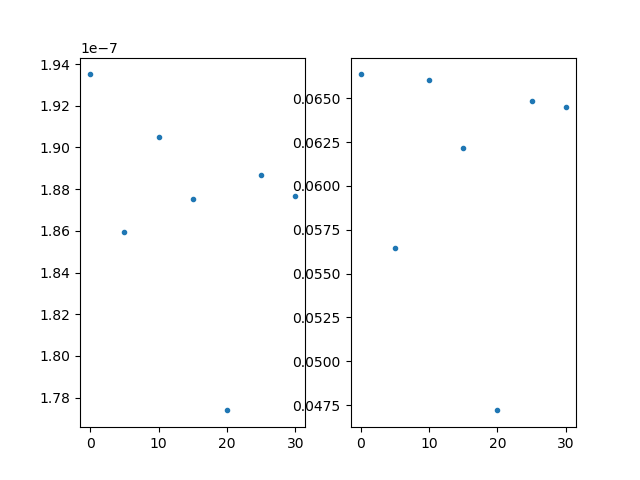

In [109]:
tlst = list(range(0,35,5))
Ic0lst = []
Tefflst = []

for idx in range(1573,1579+1):
    Ic0, Teff = fit_hist_by_id(idx, EJ = 2, Ec = 0.05, bins=10)
    print( 'Run id {:.0f},Ic0 = {:2.1f}nA, Teff = {:2.0f}mK )'.format(idx, Ic0*1e9, Teff*1e3))
    Ic0lst.append(Ic0)
    Tefflst.append(Teff)

plt.close('all')
f,ax=plt.subplots(1,2)
ax[0].plot(tlst, Ic0lst, '.')
ax[1].plot(tlst, Tefflst, '.')
plt.show()

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


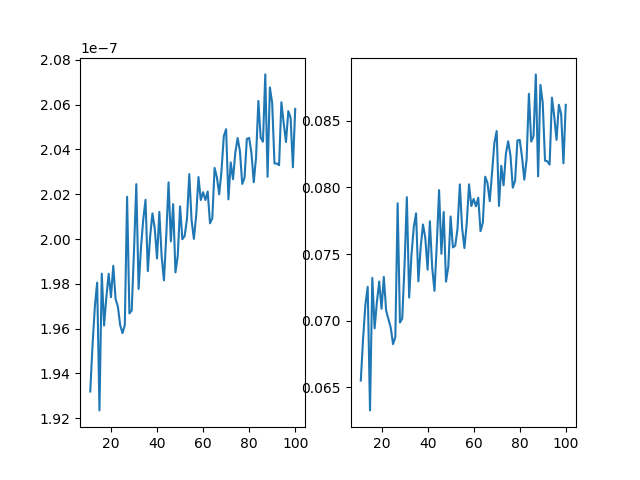

In [105]:
blst = list(range(11,101))
Ic0lst = []
Tefflst = []
for b in blst:
    Ic0, Teff = fit_hist_by_id(1573, EJ = 2, Ec = 0.05, bins = b)
    Ic0lst.append(Ic0)
    Tefflst.append(Teff)

plt.close('all')
f,ax=plt.subplots(1,2)
ax[0].plot(blst, Ic0lst, '-')
ax[1].plot(blst, Tefflst, '-')
plt.show()

### 12/19

**Plan**
- check R0 for AWG&6220 at T= 45mK, cos(B)=0.15 (same iter time)
- 

<IPython.core.display.Javascript object>


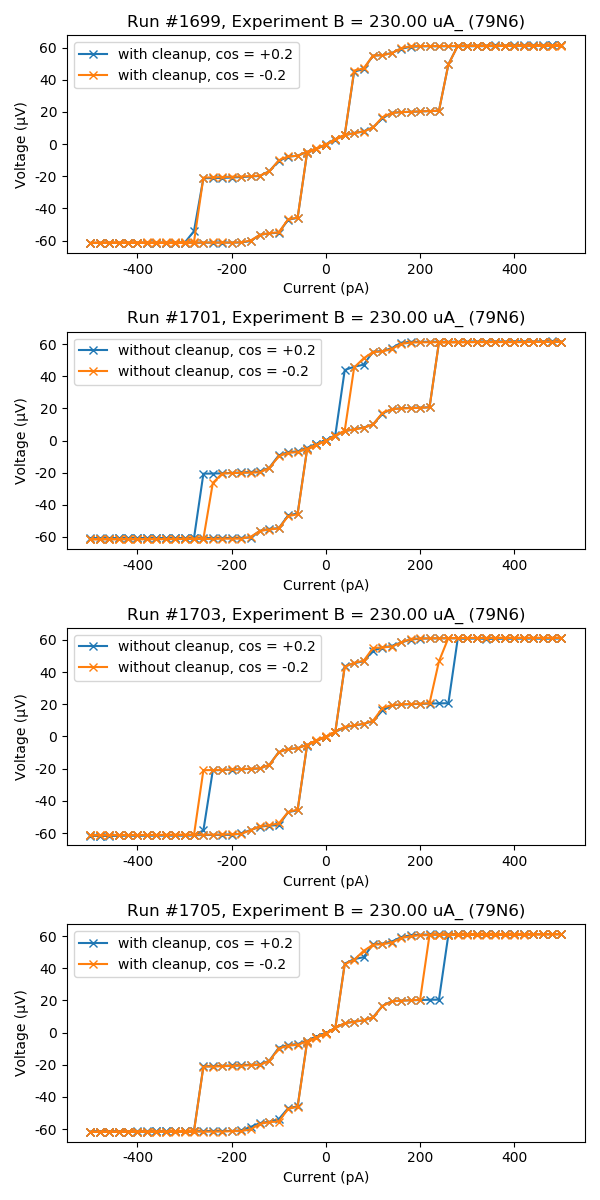

In [106]:
# labels = [ 'B = {:1.2e}'.format(B) for B in [224e-6,230e-6]]

# with cleanup Bfield.set(0), [1698,1699+

# without cleanup Bfield.set(0), [1700,1701]
# without cleanup Bfield.set(0), [1702,1703]

f,ax=plt.subplots(4,1, figsize = (6,12))
ax = ax.flatten()

labels = 'with cleanup, cos = +0.2','with cleanup, cos = -0.2'
batch_plot_by_id([1698,1699],
                 labels = labels, 
                 marker = 'x', ls = '-',
                ax = ax[0])

labels = 'without cleanup, cos = +0.2','without cleanup, cos = -0.2'
batch_plot_by_id([1700,1701],
                 labels = labels, 
                 marker = 'x', ls = '-',
                ax = ax[1])

labels = 'without cleanup, cos = +0.2','without cleanup, cos = -0.2'
batch_plot_by_id([1702,1703],
                 labels = labels, 
                 marker = 'x', ls = '-',
                ax = ax[2])

labels = 'with cleanup, cos = +0.2','with cleanup, cos = -0.2'
batch_plot_by_id([1704,1705],
                 labels = labels, 
                 marker = 'x', ls = '-',
                ax = ax[3])

plt.tight_layout()

The take-away is that the stocastic is more dominant 

<IPython.core.display.Javascript object>


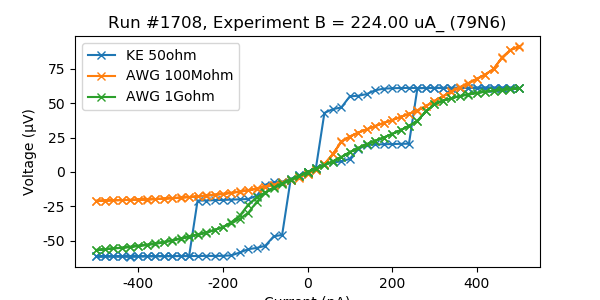

In [107]:
f,ax=plt.subplots(1,1, figsize = (6,3))

labels = 'KE 50ohm','AWG 100Mohm', 'AWG 1Gohm'
batch_plot_by_id([1704,1706,1708],
                 labels = labels, 
                 marker = 'x', ls = '-',
                 ax = ax)

<IPython.core.display.Javascript object>


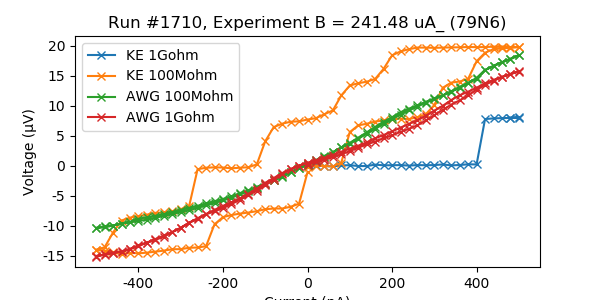

In [108]:
f,ax=plt.subplots(1,1, figsize = (6,3))

labels = 'KE 1Gohm','KE 100Mohm','AWG 100Mohm', 'AWG 1Gohm'
batch_plot_by_id([1716,1714,1712,1710],
                 labels = labels, 
                 marker = 'x', ls = '-',
                 ax = ax)